# Example of usage Spark OCR for Table Recognition

This notebook demonstrate pipeline for extract tabular data from image of the table.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""

spark_ocr_jar_path = "../../target/scala-2.11"

In [3]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.7.0+spark30.tar.gz

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [2]:
import os

os.environ['SPARK_OCR_LICENSE'] = license

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [ ]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

## Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/1-s2__3.jpg
    Resolution: 150 dpi
    Width: 1219 px
    Height: 1632 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


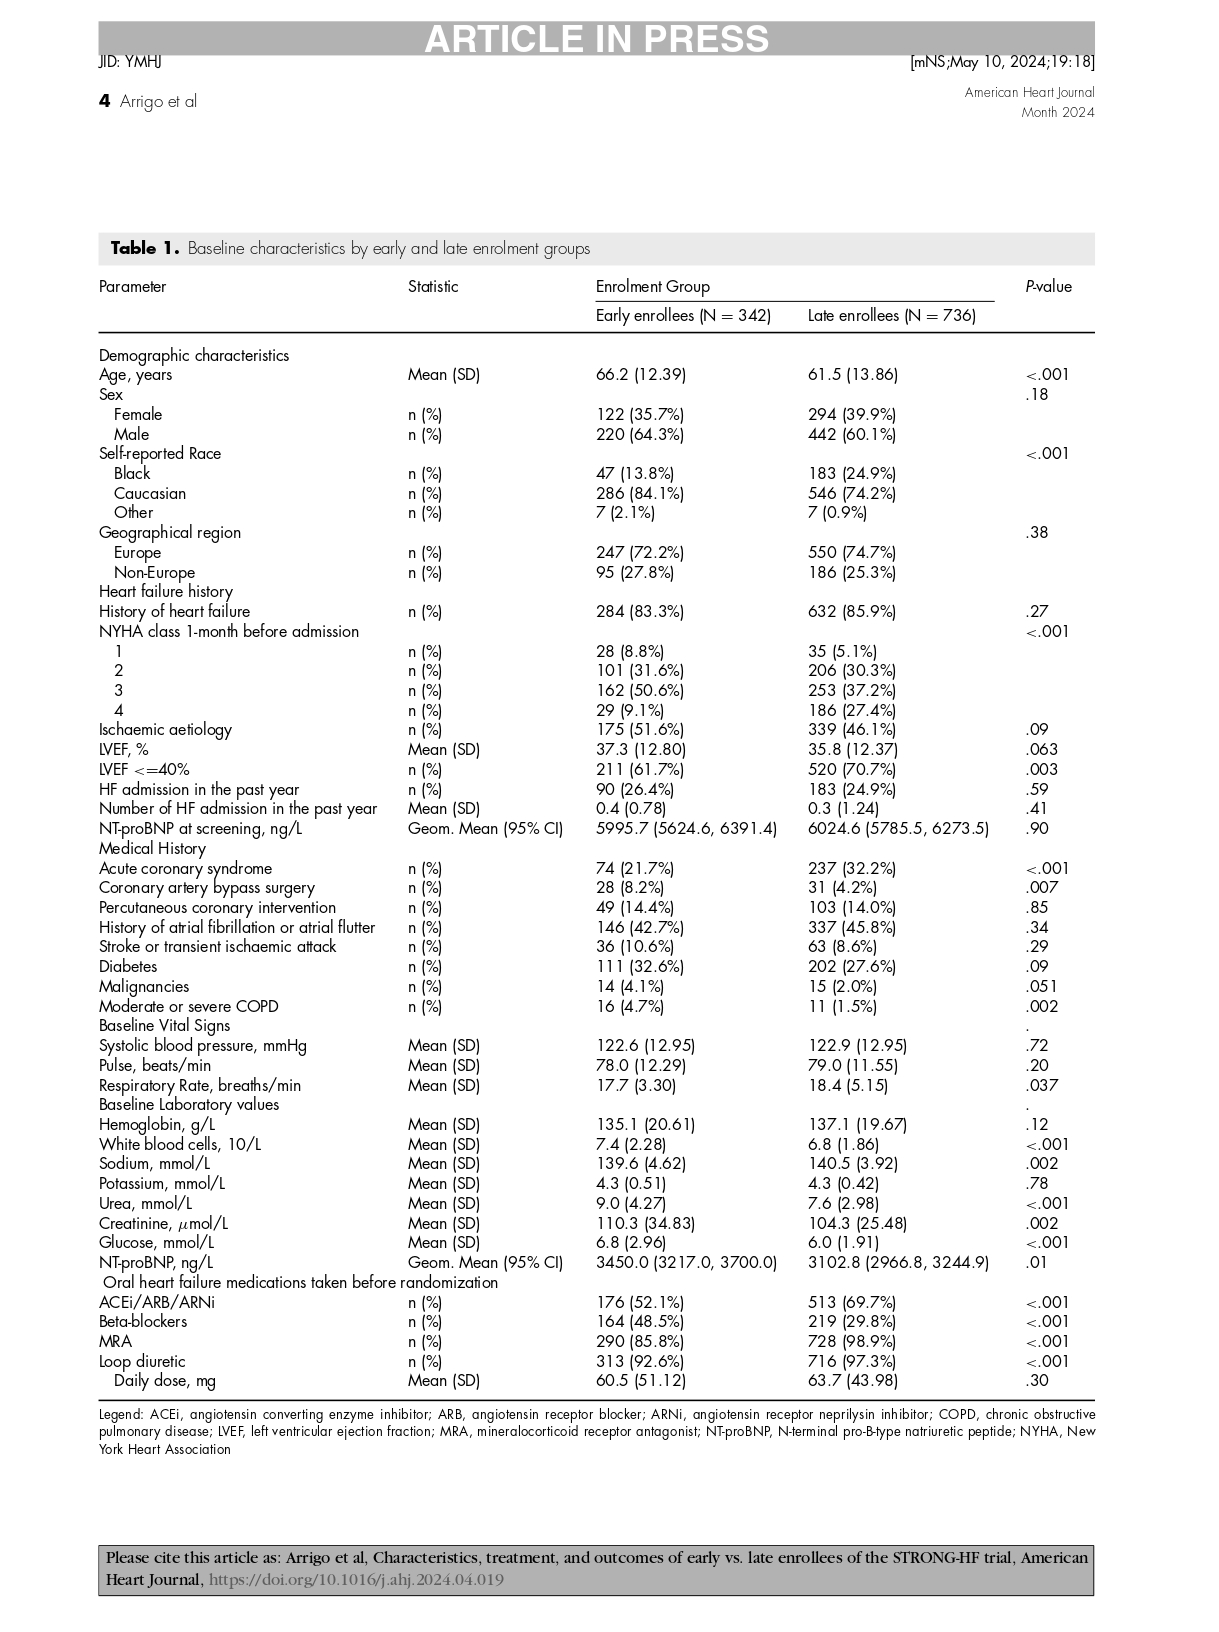

In [15]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_table, display_tables
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

import pkg_resources
test_image_path = "./data/tab_images/1-s2__3.jpg"
image_df= spark.read.format("binaryFile").load(test_image_path)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [5]:
binary_to_image = BinaryToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
    .pretrained("table_detection_v3", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions") \
    .setScoreThreshold(0.5) \
    .setApplyCorrection(True)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image")

cell_detector = ImageDocumentRegionDetector \
    .pretrained("region_cell_detection_v2", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

draw_regions = ImageDrawRegions() \
    .setInputCol("table_image") \
    .setInputRegionsCol("cells") \
    .setOutputCol("image_with_cells_regions") \
    .setRectColor(Color.green)

img_to_hocr = ImageToHocr() \
      .setInputCol("table_image") \
      .setOutputCol("hocr") \
      .setIgnoreResolution(True) \
      .setOcrParams(["preserve_interword_spaces=1", ])

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("table") \
    .setUseCellsCol("cells")
    
pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    cell_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

table_detection_v3 download started this may take some time.
Approximate size to download 23.1 MB
table_detection_v3 download started this may take some time.
Approximate size to download 23.1 MB
Download done! Loading the resource.
region_cell_detection_v2 download started this may take some time.
Approximate size to download 23.1 MB
region_cell_detection_v2 download started this may take some time.
Approximate size to download 23.1 MB
Download done! Loading the resource.


## Run pipeline

In [16]:
results = pipeline.transform(image_df).cache()

## Display images with detected cells

Estimating resolution as 160                                        (0 + 1) / 1]



    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/1-s2__3.jpg
    Resolution: 0 dpi
    Width: 1010 px
    Height: 1138 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


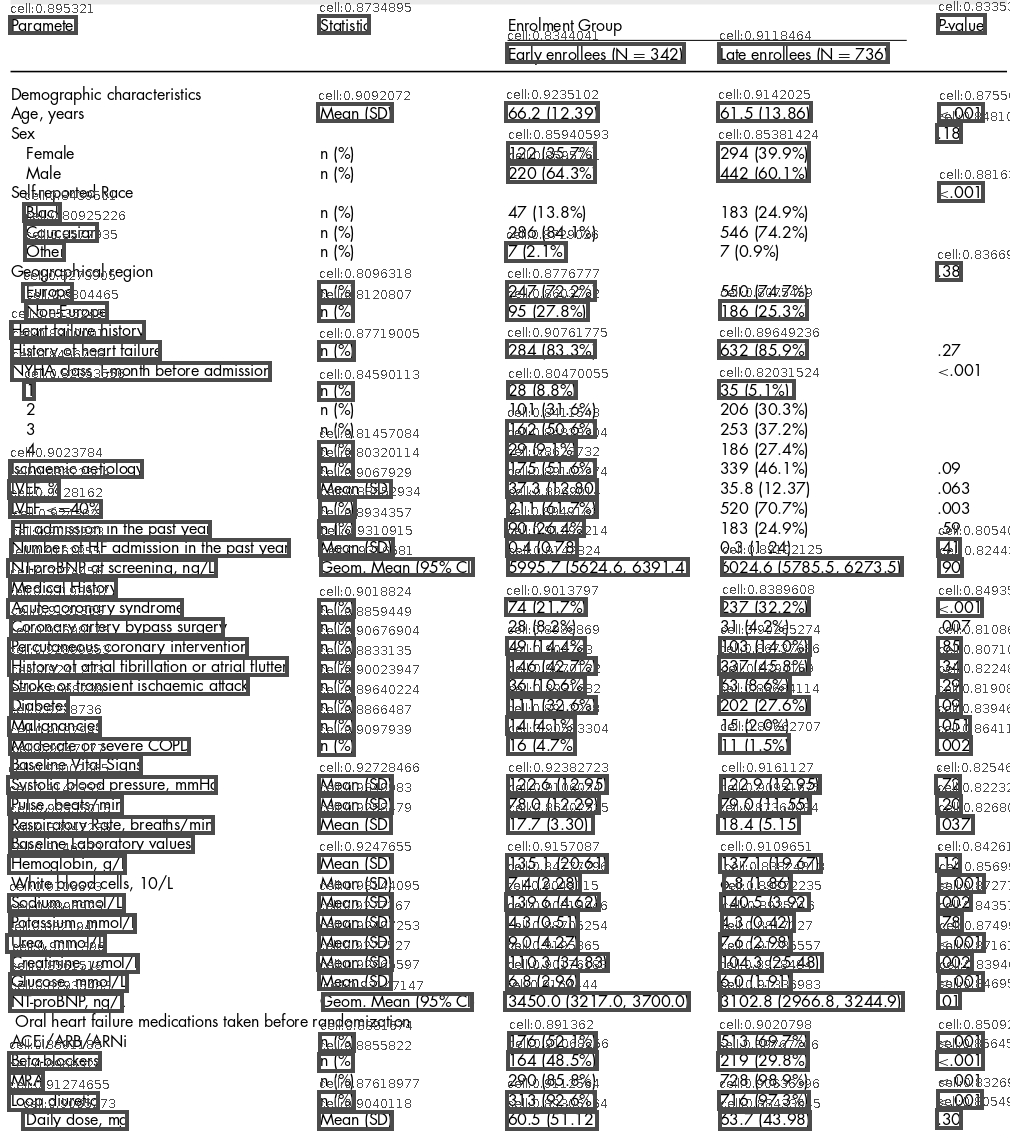

In [17]:
display_images(results, "image_with_cells_regions")

## Display recognized tables

In [18]:
display_tables(results, empty_val = "")

Filename: 1-s2__3.jpg
Page: 0
Table: 0
Number of Columns: 5


col0,col1,col2,col3,col4
Parameter,Statistic,Enrolment Group,,Pyalue
,,Early enrollees (N= 342),Late enrollees (N = 736),
Demographic characteristics,,,,
"Age, years",‘Mean (SD),66.2 (12.39),61.5 (13.86),<.001
Sex,,,,18
Female,n (%,122 (35.7%),294 (39.9%) 442 (60.1%),
Male,n (%,220 (64.3%),294 (39.9%) 442 (60.1%),
Selfreported Race,,,,<.001
Black,n(%,47 (13.8%),183 (24.9%),
Caucasian,n (%,286 (84.1%),5A6 (74.2%),


## Pipeline with csv output format

In [19]:
hocr_to_csv_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("table") \
    .setUseCellsCol("cells") \
    .setOutputFormat(TableOutputFormat.CSV)
    
pipeline_csv = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    cell_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_csv_table
])

## Display CSV

In [22]:
results_csv = pipeline_csv.transform(image_df).cache()
print(results_csv.select("table").collect()[0].table)

Estimating resolution as 160                                        (0 + 1) / 1]


Parameter,Statistic,Enrolment Group,,Pyalue
,,Early enrollees (N= 342),Late enrollees (N = 736),
Demographic characteristics,,,,
"Age, years",‘Mean (SD),66.2 (12.39),61.5 (13.86),<.001
Sex,,,,18
Female,n (%,122 (35.7%),294 (39.9%) 442 (60.1%),
Male,n (%,220 (64.3%),294 (39.9%) 442 (60.1%),
Selfreported Race,,,,<.001
Black,n(%,47 (13.8%),183 (24.9%),
Caucasian,n (%,286 (84.1%),5A6 (74.2%),
Other,n (%,7 (2.1%),7 (0.9%),
Geographical region,,,,38
Europe,n (%,247 (72.2%),550 (74.7%),
Non-Europe,n (%,95 (27.8%),186 (25.3%),
Heart failure history,,,,
History of heart failure,n(%,284 (83.3%),632 (85.9%),27
NYHA class I-month before admission,,,,<.001
1,n (%,28 (8.8%),35 (5.1%),
2,n (%,101 (31.6%),206 (30.3%),
3,n (%,162 (50.6%),253 (37.2%),
4,n (%,29 (9.1%),186 (27.4%),
Ischaemic aetiology,n (%,175 (51.6%),339 (46.1%),09
"IVEF, %",‘Mean (SD),37.3 (12.80),35.8 (12.37),063
IEF <=40%,n (%,211 (61.7%),520 (70.7%),003
HF admission in the past year,n (%,90 (26.4%),183 (24.9%),59
Number of HF admiss